In [43]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Chapter 6
## Logic Definition of Generalization:
1. Show empirically that the information limit of 2 prediction bits per parameter also holds for nearest neighbors.

In [37]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

def n_full(d):
    return 2**d

def generate_dataset(n_samples, n_dimensions):
    """Generates a dataset of random points and random labels."""
    X = np.random.rand(n_samples, n_dimensions)
    y = np.random.randint(2, size=n_samples)  # Binary labels
    return X, y

def train_test_split(X, y, test_size=0.5):
    """Splits the dataset into training and test sets."""
    n_samples = X.shape[0]
    n_test = int(n_samples * test_size)
    indices = np.random.permutation(n_samples)
    training_idx, test_idx = indices[n_test:], indices[:n_test]
    return X[training_idx], X[test_idx], y[training_idx], y[test_idx]

def count_required_points(X, y):
    """Counts how many points are required to perfectly predict the training set using 1-NN."""
    # split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_train, y_train)
    predictions = knn.predict(X_test)
    
    correct_predictions = (predictions == y_test)
    required_points_indices = np.where(correct_predictions == True)[0]
    return len(required_points_indices)

def experiment(n_dimensions, n_samples):
    """Conducts the experiment for a given dimensionality and number of functions."""
    required_points = []
    
    for _ in range(n_dimensions * 8):
        X, y = generate_dataset(n_samples, n_dimensions)
        n_required = count_required_points(X, y)
        required_points.append(n_required)
        
    avg_required_points = np.mean(required_points) * 2 # Multiply by 2 because we only used half of the data
    return n_dimensions, avg_required_points, n_samples / avg_required_points

# Define the dimensions and number of functions for each dimensionality
dimensions_functions = [(x, n_full(x)) for x in range(1, 10)]

# Conduct the experiment for each dimensionality
results = [experiment(d, n) for d, n in dimensions_functions]

results = pd.DataFrame(results, columns=["n_dimensions", "avg_predicted_points", "n_full/n_average"])
print(results)

   n_dimensions  avg_predicted_points  n_full/n_average
0             1              1.500000          1.333333
1             2              2.125000          1.882353
2             3              3.583333          2.232558
3             4              7.687500          2.081301
4             5             15.600000          2.051282
5             6             31.833333          2.010471
6             7             62.785714          2.038680
7             8            129.375000          1.978744
8             9            258.166667          1.983215


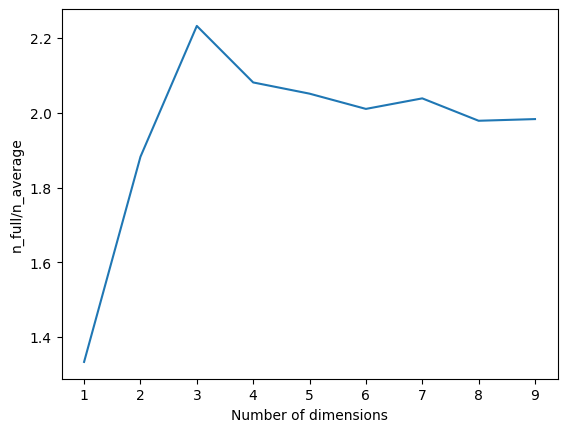

In [38]:
# Plot the results
plt.plot(results["n_dimensions"], results["n_full/n_average"])
plt.xlabel("Number of dimensions")
plt.ylabel("n_full/n_average")
plt.show()

2. Extend your experiments to multi-class classification.

C:\Users\alexz\AppData\Local\Temp\ipykernel_23712\3273237750.py:30: RuntimeWarning: divide by zero encountered in scalar divide
  return n_dimensions, avg_required_points, n_samples / avg_required_points


   n_dimensions  avg_predicted_points  n_full/n_average
0             1              0.000000               inf
1             2              0.125000         32.000000
2             3              0.916667          8.727273
3             4              2.062500          7.757576
4             5              3.450000          9.275362
5             6              6.375000         10.039216
6             7             13.071429          9.792350
7             8             25.781250          9.929697
8             9             50.250000         10.189055


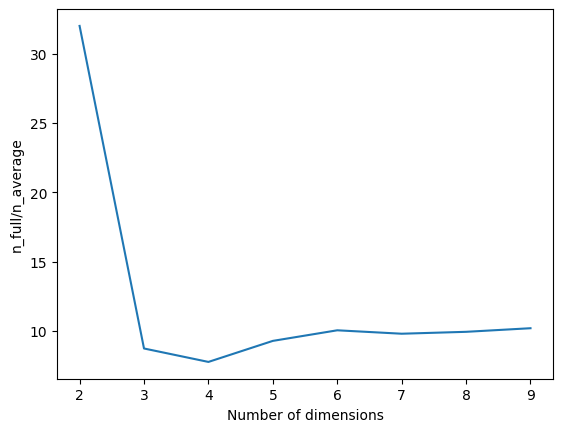

In [40]:
def generate_dataset_multi_class(n_samples, n_dimensions, n_classes):
    """Generates a dataset of random points and random labels."""
    X = np.random.rand(n_samples, n_dimensions)
    y = np.random.randint(n_classes, size=n_samples)  # Binary labels
    return X, y

def count_required_points_multi_class(X, y):
    """Counts how many points are required to perfectly predict the training set using 1-NN."""
    # split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_train, y_train)
    predictions = knn.predict(X_test)
    
    correct_predictions = (predictions == y_test)
    required_points_indices = np.where(correct_predictions == True)[0]
    return len(required_points_indices)

def experiment_multi_class(n_dimensions, n_samples, n_classes):
    """Conducts the experiment for a given dimensionality and number of functions."""
    required_points = []
    
    for _ in range(n_dimensions * 8):
        X, y = generate_dataset_multi_class(n_samples, n_dimensions, n_classes)
        n_required = count_required_points_multi_class(X, y)
        required_points.append(n_required)
        
    avg_required_points = np.mean(required_points) * 2 # Multiply by 2 because we only used half of the data
    return n_dimensions, avg_required_points, n_samples / avg_required_points

# Define the dimensions and number of functions for each dimensionality
dimensions_functions = [(x, n_full(x)) for x in range(1, 10)]

# Conduct the experiment for each dimensionality
results = [experiment_multi_class(d, n, 10) for d, n in dimensions_functions]

results = pd.DataFrame(results, columns=["n_dimensions", "avg_predicted_points", "n_full/n_average"])
print(results)

# Plot the results
plt.plot(results["n_dimensions"], results["n_full/n_average"])
plt.xlabel("Number of dimensions")
plt.ylabel("n_full/n_average")
plt.show()

## Finite State Machine Generalization:
1. Implement a program that automatically creates a set of if-then clauses from the training table of a binary dataset of your choice. Implement different strategies to minimize the number of if-then clauses. Document your strategies, the number of resulting conditional clauses, and the accuracy achieved.

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from itertools import combinations

# Generate a synthetic binary dataset
np.random.seed(0)
n_samples = 100
n_features = 4
X = np.random.randint(2, size=(n_samples, n_features))  # Features
y = np.random.randint(2, size=n_samples)  # Binary target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

def generate_if_then_clauses(X, y):
    """
    Generates if-then clauses from the training data and attempts to minimize them.
    """
    clauses = []
    for index, row in enumerate(X):
        clause = "IF "
        for i, val in enumerate(row):
            clause += f"feature_{i} == {val} AND "
        clause = clause.rstrip(" AND ") + f" THEN outcome == {y[index]}"
        clauses.append(clause)
    
    # Basic minimization strategy: Deduplication
    unique_clauses = list(set(clauses))
    
    return unique_clauses

def evaluate_clauses(clauses, X_test, y_test):
    """
    Evaluates the generated clauses on a test set for accuracy.
    """
    predictions = []
    for test_row in X_test:
        prediction = None
        for clause in clauses:
            condition, outcome = clause.split(" THEN ")
            condition = condition.replace("IF ", "").split(" AND ")
            if all(f"feature_{i} == {int(test_row[i])}" in condition for i in range(len(test_row))):
                _, outcome_val = outcome.split(" == ")
                prediction = int(outcome_val)
                break
        if prediction is None:
            prediction = 0  # Default to 0 if no clause matches
        predictions.append(prediction)
    
    accuracy = accuracy_score(y_test, predictions)
    return accuracy

# Generate and evaluate clauses
clauses = generate_if_then_clauses(X_train, y_train)
accuracy = evaluate_clauses(clauses, X_test, y_test)

len(clauses), accuracy

(27, 0.5666666666666667)

In [21]:
# Function to generate and evaluate synthetic datasets of varying complexity
def experiment_with_synthetic_datasets(n_instances, feature_counts):
    results = []
    for n_features in feature_counts:
        # Generate a synthetic dataset
        X = np.random.randint(2, size=(n_instances, n_features))
        y = np.random.randint(2, size=n_instances)
        
        # Split the dataset into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        
        # Generate and evaluate clauses
        clauses = generate_if_then_clauses(X_train, y_train)
        accuracy = evaluate_clauses(clauses, X_test, y_test)
        
        results.append({"n_features": n_features, "n_clauses": len(clauses), "accuracy": accuracy})
    return pd.DataFrame(results)

# Experiment with synthetic datasets with varying number of features
n_instances = 100
feature_counts = [2, 4, 6, 8]
synthetic_results = experiment_with_synthetic_datasets(n_instances, feature_counts)
synthetic_results

,n_features,n_clauses,accuracy
0,2,8,0.466667
1,4,29,0.466667
2,6,49,0.533333
3,8,61,0.633333


In [22]:
titanic_data = pd.read_csv('data/titanic.csv')

# Select a subset of columns for simplicity and handle categorical variables
features_to_use = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Survived']
titanic_data = titanic_data[features_to_use].dropna()

# Convert 'Sex' to a binary variable
titanic_data['Sex'] = titanic_data['Sex'].map({'male': 0, 'female': 1})

# Prepare the data
X_titanic = titanic_data.drop('Survived', axis=1).values
y_titanic = titanic_data['Survived'].values

# Split the dataset
X_train_titanic, X_test_titanic, y_train_titanic, y_test_titanic = train_test_split(X_titanic, y_titanic, test_size=0.3, random_state=42)

# Generate and evaluate clauses on the Titanic dataset
clauses_titanic = generate_if_then_clauses(X_train_titanic, y_train_titanic)
accuracy_titanic = evaluate_clauses(clauses_titanic, X_test_titanic, y_test_titanic)

len(clauses_titanic), accuracy_titanic

(92, 0.6902985074626866)

## Compression
1. Create a long random string using a Python program, and use a lossless compression algorithm of your choice to compress the string. Note the compression ratio.

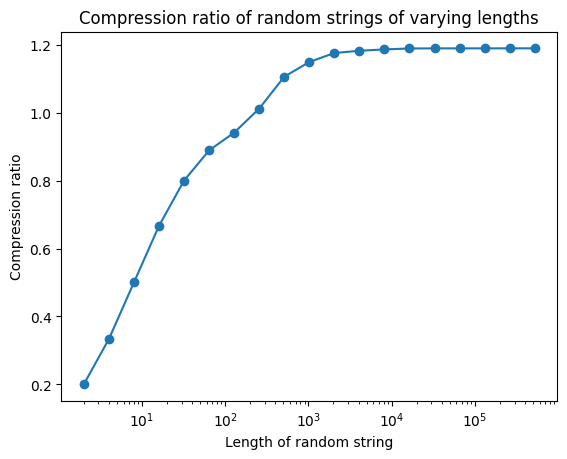

In [32]:
import zlib
import string
import random

def get_compression_ratio_of_random_string(length_of_string):
    """Generates a random string and returns its compression ratio using zlib."""
    random_string = (''.join(random.choices(string.printable, k=length_of_string))).encode('utf-8')
    compressed_string = zlib.compress(random_string)
    compression_ratio = len(random_string) / len(compressed_string)
    return compression_ratio

# plot the compression ratio of random strings of varying lengths
string_lengths = [2**i for i in range(1, 20)]
compression_ratios = [get_compression_ratio_of_random_string(length) for length in string_lengths]

plt.plot(string_lengths, compression_ratios, marker='o')
plt.xscale('log')
plt.xlabel('Length of random string')
plt.ylabel('Compression ratio')
plt.title('Compression ratio of random ascii strings of varying lengths')
plt.show()

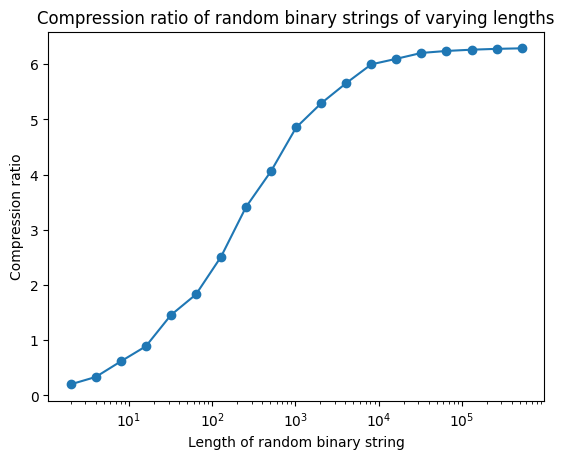

In [33]:
def get_compression_ratio_of_random_binary_string(length_of_string):
    """Generates a random binary string and returns its compression ratio using zlib."""
    random_string = ''.join(random.choices(['0', '1'], k=length_of_string)).encode('utf-8')
    compressed_string = zlib.compress(random_string)
    compression_ratio = len(random_string) / len(compressed_string)
    return compression_ratio

# plot the compression ratio of random binary strings of varying lengths
string_lengths = [2**i for i in range(1, 20)]
compression_ratios = [get_compression_ratio_of_random_binary_string(length) for length in string_lengths]

plt.plot(string_lengths, compression_ratios, marker='o')
plt.xscale('log')
plt.xlabel('Length of random binary string')
plt.ylabel('Compression ratio')
plt.title('Compression ratio of random binary strings of varying lengths')
plt.show()

2. What is the expected compression ratio in (a)? Explain why?

    The expected compression ratio is 1:1. The string is random, so there is no pattern to exploit for compression. However, the random string is not truly random due to the limitations of the random number generator. The compression algorithm will exploit the non-randomness of the string to achieve a compression ratio more than 1:1, as we can see, the compression ratio of ascii string converges to 1.2 using zlib.

    For a binary string, the limitation is more pronounced, thus the compression ratio is around 6. 

# Chapter 8
## Upper Bounds
1. Do Exercise 40.8 in MacKay’s book (MacKay 2003). It is cited
here as follows:
    
    > Estimate in bits the total sensory experience that you
    have had in your life – visual information, auditory
    information, etc. Estimate how much information you
    have memorized. Estimate the information content of
    the works of Shakespeare. Compare these with the
    capacity of your brain assuming you have neurons
    each making 1000 synaptic connections and that the
    (information) capacity result for one neuron (two bits
    per connection) applies. Is your brain full yet?
    > 
    
    Note that MacKay is right to suggest using information
    capacity for this estimate as image and acoustic data are
    relatively high dimensional and he also suggests 1000
    connections per neuron.

# Chapter 9
Implement a deep convolutional neural network from scratch using a
popular deep learning framework (e.g., TensorFlow or PyTorch). Train
and evaluate the network on a standard image classification dataset,
such as CIFAR-10 or MNIST. First, experiment blindly with various
hyperparameters and architectures and observe the model’s
performance. Second, apply the measurements proposed in this book
to reduce the hyperparameter search space and observe the model’s
performance.

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from livelossplot import PlotLosses

# Define a simple CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Load CIFAR-10 data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

# Initialize the network and optimizer
net = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

plotlosses = PlotLosses()
# Training loop
for epoch in range(30):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    plotlosses.update({'loss': running_loss})
    plotlosses.send()

print('Finished Training')

Files already downloaded and verified
Files already downloaded and verified
